## Convolutional Neural Network



In this notebook we have analyzed the performance of 4 developed models (basic ConvNet, VGG16, ResNet and UNet) for the task of binary classification. 
For each model, we analyze the following:   
1. Plots for Epoch vs Loss and Epoch vs Accuracy on training and validation sets.
2. Show the test accuracy
3. Show exmaples of correctly and misclassified images.

In [38]:
from helpers import create_dataloader, create_plots
from models.catsvsdogsmodel import CatsVsDogsModel
from model_eval import get_latest_checkpoint, get_checkpoint_by_model_number, get_model_score
import torch.nn as nn
import pickle
from tqdm import tqdm
from torchsummary import summary
from models.customVgg import custom_vgg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [39]:
# load loss function
criterion = nn.BCELoss()

## Prepare the data.

In [40]:
BATCH_SIZE = 4

train_data_path = "data/train/"
val_data_path = "data/val/"
test_data_path = "data/test/"

train_dataloader = create_dataloader(
    data_path=train_data_path,
    batch_size=BATCH_SIZE
)

val_dataloader = create_dataloader(
    data_path=val_data_path,
    batch_size=BATCH_SIZE
)

test_dataloader = create_dataloader(
    data_path=test_data_path,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x16a29bd10>, <torch.utils.data.dataloader.DataLoader object at 0x2838d26c0>)
Length of train dataloader: 5000 batches of 4
Length of val dataloader: 623 batches of 4
Length of test dataloader: 625 batches of 4


## Task 1

Set the network architecture by sequentially adding layers to it:
1. A convolutional layer with 16 neurons, filter size 3x3. Activation function - 'relu'
2. MaxPooling layer with filter size 2x2.
3. A convolutional layer with 32 neurons, filter size 3x3. Activation function - 'relu'
4. MaxPooling layer with filter size 2x2.
5. A convolutional layer with 64 neurons, filter size 3x3. Activation function - 'relu'
6. MaxPooling layer with filter size 2x2.
7. flatten, which makes a one-dimensional vector of the resulting feature maps.
8. A fully connected layer with 64 neurons. Activation function - 'relu'
9. Use Dropout (0.5) which excludes the edge from the current layer in the computational graph with a 50% probability to avoid overfitting.
10. A fully connected layer with 1 neuron. Activation function - 'sigmoid', because binary classification model.


In [41]:
task_name = "task1"
EPOCHS = 20

In [42]:
# load model
model = CatsVsDogsModel()
checkpoint = get_latest_checkpoint(task_name=task_name)
model.load_state_dict(checkpoint['model_state_dict'])

Checkpoint 20 loaded


<All keys matched successfully>

In [43]:
# model training done in task1.py
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 148, 148]             448
              ReLU-2         [-1, 16, 148, 148]               0
         MaxPool2d-3           [-1, 16, 74, 74]               0
            Conv2d-4           [-1, 32, 72, 72]           4,640
              ReLU-5           [-1, 32, 72, 72]               0
         MaxPool2d-6           [-1, 32, 36, 36]               0
            Conv2d-7           [-1, 64, 34, 34]          18,496
              ReLU-8           [-1, 64, 34, 34]               0
         MaxPool2d-9           [-1, 64, 17, 17]               0
           Linear-10                   [-1, 64]       1,183,808
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 1]              65
          Sigmoid-14                   

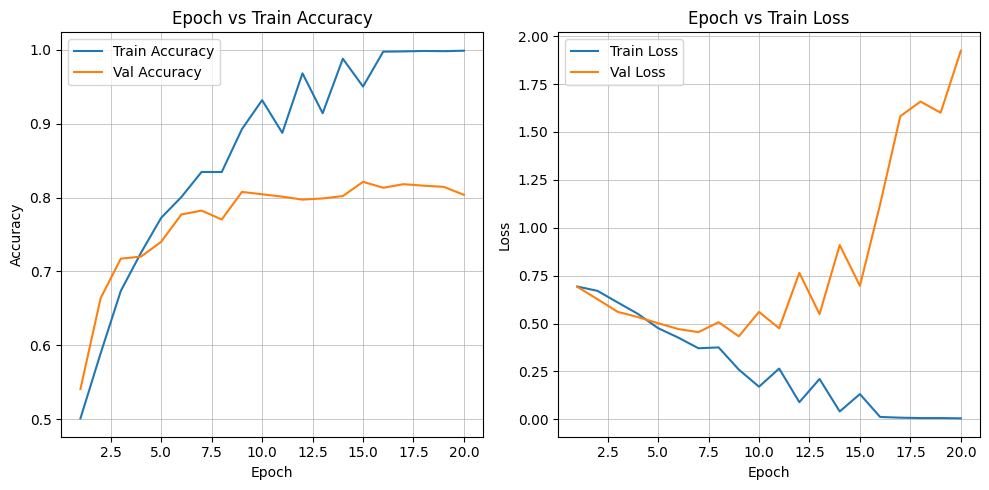

In [44]:
# Plot Epoch vs Accuracy and Epoch vs Loss
metrics_file_path = lambda metric: f"checkpoints/{task_name}/{task_name}-{metric}.pkl"

with open(metrics_file_path("train-losses"), 'rb') as f:
    epoch_losses = pickle.load(f)
with open(metrics_file_path("train-accuracys"), 'rb') as f:
    epoch_accuracys = pickle.load(f)
with open(metrics_file_path("val-accuracys"), 'rb') as f:
    epoch_val_accuracys = pickle.load(f)
with open(metrics_file_path("val-losses"), 'rb') as f:
    epoch_val_losses = pickle.load(f)

create_plots(
    train_accuracy_list=epoch_accuracys,
    train_loss_list=epoch_losses, 
    val_accuracy_list=epoch_val_accuracys,
    val_loss_list=epoch_val_losses,
    task_name=f"{task_name}",    
    epoch_list=list(range(1, len(epoch_accuracys)+1))
)

Looks like best model performance is achieved at 15 epochs. So we will use that model for further analysis.

In [49]:
# check model accuracy
best_model_number = 15

best_checkpoint = get_checkpoint_by_model_number(
    task_name=task_name,
    model_number=best_model_number)

model.load_state_dict(checkpoint['model_state_dict'])

Checkpoint 15 loaded


<All keys matched successfully>

In [50]:
test_accuracy, test_loss = get_model_score(
    model=model,
    dataloader=test_dataloader,
    criterion=criterion)

print(f"Test Accuracy: {test_accuracy * 100:.3f}% \nTest Loss: {test_loss:.3f}")

100%|██████████| 625/625 [00:08<00:00, 70.97it/s]

Test Accuracy: 80.560% 
Test Loss: 1.275


In [46]:
# finding misclassified images
incorrect_examples = []
correct_cat_examples = []
correct_dog_examples = []

model.eval()
for inputs, labels in tqdm(test_dataloader):
    outputs = model(inputs).squeeze()
    preds = (outputs > 0.5) * 1.0
    for i, (pred, label) in enumerate(zip(preds, labels)):
        if pred == label:
            if label.item() == 0:
                correct_cat_examples.append(inputs[i])
            elif label.item() ==  1:
                correct_dog_examples.append(inputs[i])
        else:
            if outputs[i] > 0.75:
                incorrect_examples.append(inputs[i])
    if min(len(incorrect_examples), len(correct_cat_examples), len(correct_dog_examples)) >= 1:
        break

  1%|          | 5/625 [00:00<00:13, 44.74it/s]


In [47]:
incorrect = incorrect_examples[0].permute(1, 2, 0)
cat = correct_cat_examples[0].permute(1, 2, 0)
dog = correct_dog_examples[0].permute(1, 2, 0)

len(incorrect_examples), len(correct_cat_examples), len(correct_dog_examples)

(1, 11, 9)

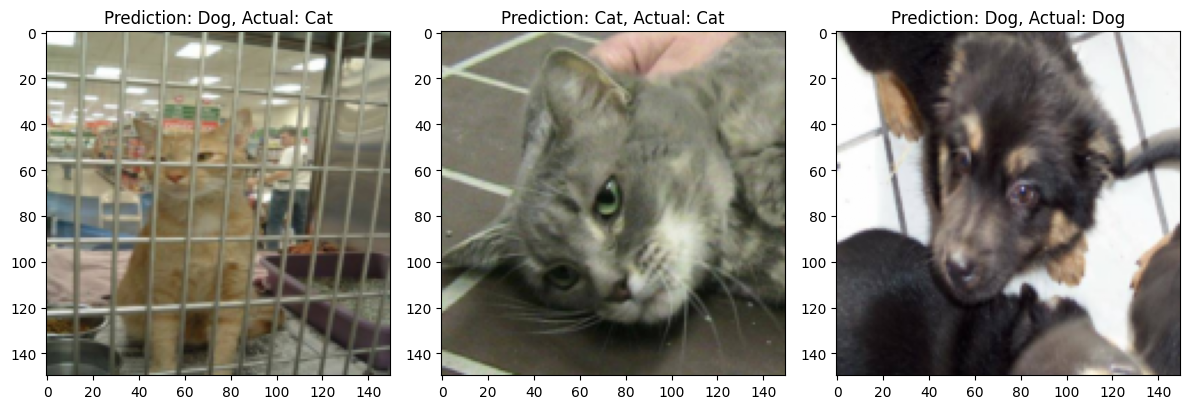

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Display img1 on the first subplot
axs[0].imshow(incorrect, cmap='gray')
axs[0].set_title('Prediction: Dog, Actual: Cat')

# Display img2 on the second subplot
axs[1].imshow(cat, cmap='gray')
axs[1].set_title('Prediction: Cat, Actual: Cat')

# Display img3 on the third subplot
axs[2].imshow(dog, cmap='gray')
axs[2].set_title('Prediction: Dog, Actual: Dog')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## Task 2

Build and fit Transfer Learning model using pre-trained VGG16-model weights.


In [51]:
task_name = "task2"

In [52]:
# model training done in task2.py
model = custom_vgg()
checkpoint = get_latest_checkpoint(task_name=task_name)
model.load_state_dict(checkpoint['model_state_dict'])
summary(model, (3, 150, 150))

Checkpoint 3 loaded
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-1

We construct our model of "transfer learning" by adding two fully connected layers to VGG16

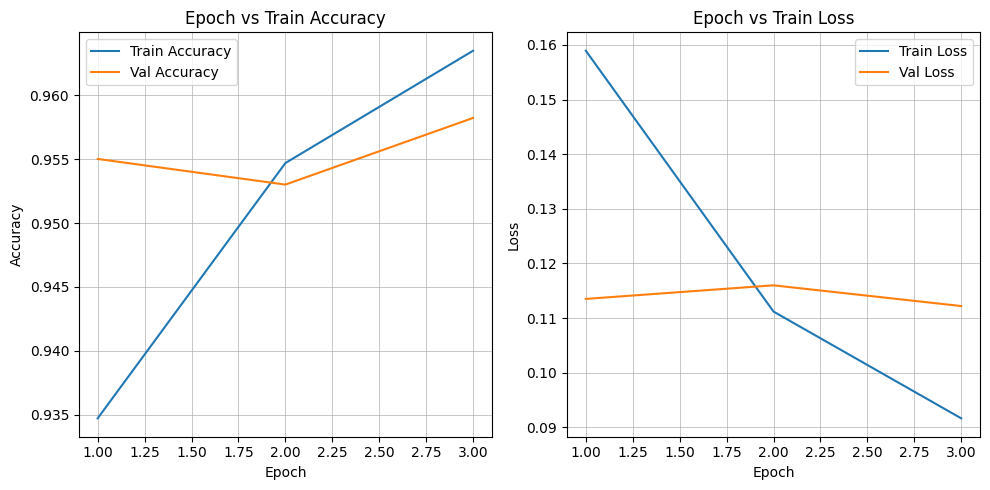

In [53]:
# Plot Epoch vs Accuracy and Epoch vs Loss
metrics_file_path = lambda metric: f"checkpoints/{task_name}/{task_name}-{metric}.pkl"

with open(metrics_file_path("train-losses"), 'rb') as f:
    epoch_losses = pickle.load(f)
with open(metrics_file_path("train-accuracys"), 'rb') as f:
    epoch_accuracys = pickle.load(f)
with open(metrics_file_path("val-accuracys"), 'rb') as f:
    epoch_val_accuracys = pickle.load(f)
with open(metrics_file_path("val-losses"), 'rb') as f:
    epoch_val_losses = pickle.load(f)

create_plots(
    train_accuracy_list=epoch_accuracys,
    train_loss_list=epoch_losses, 
    val_accuracy_list=epoch_val_accuracys,
    val_loss_list=epoch_val_losses,
    task_name=f"{task_name}",    
    epoch_list=list(range(1, len(epoch_accuracys)+1))
)

Model at epoch 3 has the best peformance well above the desired threshold. Hence we will use that for further analysis

In [54]:
# check model accuracy
best_model_number = 3

best_checkpoint = get_checkpoint_by_model_number(
    task_name=task_name,
    model_number=best_model_number)

model.load_state_dict(checkpoint['model_state_dict'])

test_accuracy, test_loss = get_model_score(
    model=model,
    dataloader=test_dataloader,
    criterion=criterion)

print(f"Test Accuracy: {test_accuracy * 100:.3f}% \nTest Loss: {test_loss:.3f}")

Checkpoint 3 loaded


  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [02:33<00:00,  4.07it/s]

Test Accuracy: 94.960% 
Test Loss: 0.123


In [19]:
# finding misclassified images
incorrect_examples = []
correct_cat_examples = []
correct_dog_examples = []

model.eval()
for inputs, labels in tqdm(test_dataloader):
    outputs = model(inputs).squeeze()
    preds = (outputs > 0.5) * 1.0
    for i, (pred, label) in enumerate(zip(preds, labels)):
        if pred == label:
            if label.item() == 0:
                correct_cat_examples.append(inputs[i])
            elif label.item() ==  1:
                correct_dog_examples.append(inputs[i])
        else:
            if outputs[i] > 0.75:
                incorrect_examples.append(inputs[i])
    if min(len(incorrect_examples), len(correct_cat_examples), len(correct_dog_examples)) >= 1:
        break

  6%|▌         | 35/625 [00:09<02:40,  3.69it/s]


In [20]:
incorrect = incorrect_examples[0].permute(1, 2, 0)
cat = correct_cat_examples[0].permute(1, 2, 0)
dog = correct_dog_examples[0].permute(1, 2, 0)

len(incorrect_examples), len(correct_cat_examples), len(correct_dog_examples)

(1, 79, 59)

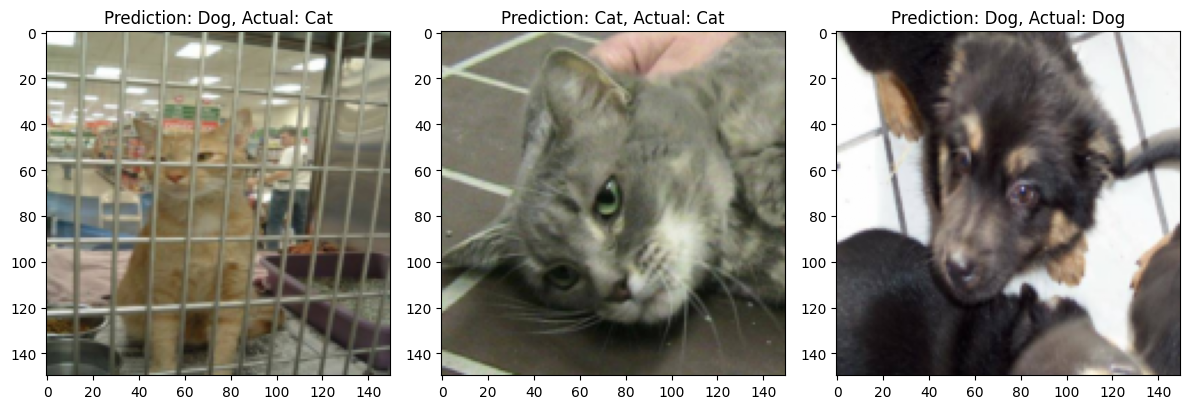

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Display img1 on the first subplot
axs[0].imshow(incorrect, cmap='gray')
axs[0].set_title('Prediction: Dog, Actual: Cat')

# Display img2 on the second subplot
axs[1].imshow(cat, cmap='gray')
axs[1].set_title('Prediction: Cat, Actual: Cat')

# Display img3 on the third subplot
axs[2].imshow(dog, cmap='gray')
axs[2].set_title('Prediction: Dog, Actual: Dog')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## Task 3

In this task, we will create and train a ResNet-based model from scratch to improve classification accuracy.


In [28]:
from models.resnet import ResNet, ResidualBlock

task_name = "task3"

In [29]:
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=1)
checkpoint = get_latest_checkpoint(task_name=task_name)
model.load_state_dict(checkpoint['model_state_dict'])

Checkpoint 5 loaded


<All keys matched successfully>

In [30]:
# model trained using task3.py

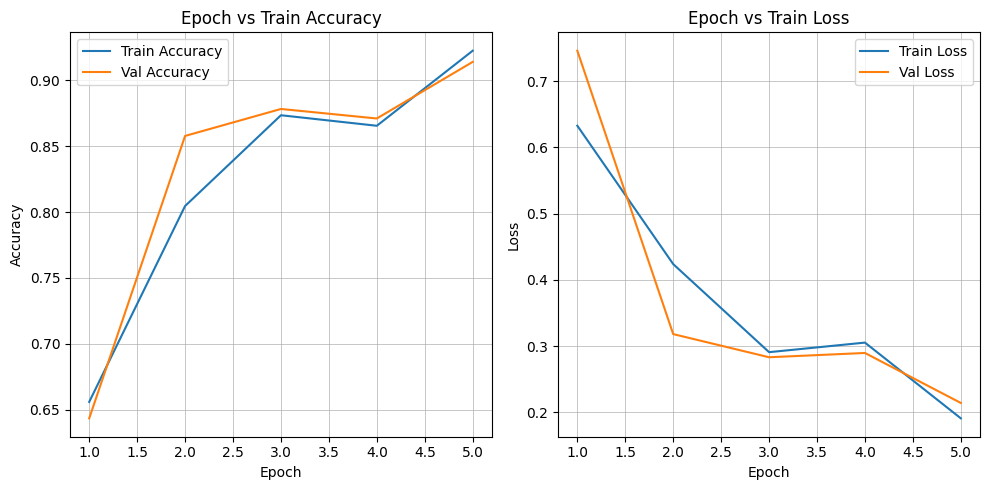

In [31]:
# Plot Epoch vs Accuracy and Epoch vs Loss
metrics_file_path = lambda metric: f"checkpoints/{task_name}/{task_name}-{metric}.pkl"

with open(metrics_file_path("train-losses"), 'rb') as f:
    epoch_losses = pickle.load(f)
with open(metrics_file_path("train-accuracys"), 'rb') as f:
    epoch_accuracys = pickle.load(f)
with open(metrics_file_path("val-accuracys"), 'rb') as f:
    epoch_val_accuracys = pickle.load(f)
with open(metrics_file_path("val-losses"), 'rb') as f:
    epoch_val_losses = pickle.load(f)

create_plots(
    train_accuracy_list=epoch_accuracys,
    train_loss_list=epoch_losses, 
    val_accuracy_list=epoch_val_accuracys,
    val_loss_list=epoch_val_losses,
    task_name=f"{task_name}",    
    epoch_list=list(range(1, len(epoch_accuracys)+1))
)

Model at epoch 5 has the best peformance well above the desired threshold. Hence we will use that for further analysis

In [32]:
# check model accuracy
best_model_number = 5

best_checkpoint = get_checkpoint_by_model_number(
    task_name=task_name,
    model_number=best_model_number)

model.load_state_dict(checkpoint['model_state_dict'])

test_accuracy, test_loss = get_model_score(
    model=model,
    dataloader=test_dataloader,
    criterion=criterion)

print(f"Test Accuracy: {test_accuracy * 100:.3f}% \nTest Loss: {test_loss:.3f}")

Checkpoint 5 loaded


  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:25<00:00, 24.26it/s]

Test Accuracy: 90.960% 
Test Loss: 0.229


In [33]:
# finding misclassified images
incorrect_examples = []
correct_cat_examples = []
correct_dog_examples = []

model.eval()
for inputs, labels in tqdm(test_dataloader):
    outputs = model(inputs).squeeze()
    preds = (outputs > 0.5) * 1.0
    for i, (pred, label) in enumerate(zip(preds, labels)):
        if pred == label:
            if label.item() == 0:
                correct_cat_examples.append(inputs[i])
            elif label.item() ==  1:
                correct_dog_examples.append(inputs[i])
        else:
            if outputs[i] > 0.75:
                incorrect_examples.append(inputs[i])
    if min(len(incorrect_examples), len(correct_cat_examples), len(correct_dog_examples)) >= 1:
        break

  0%|          | 2/625 [00:00<00:39, 15.68it/s]


In [36]:
incorrect = incorrect_examples[0].permute(1, 2, 0)
cat = correct_cat_examples[0].permute(1, 2, 0)
dog = correct_dog_examples[0].permute(1, 2, 0)

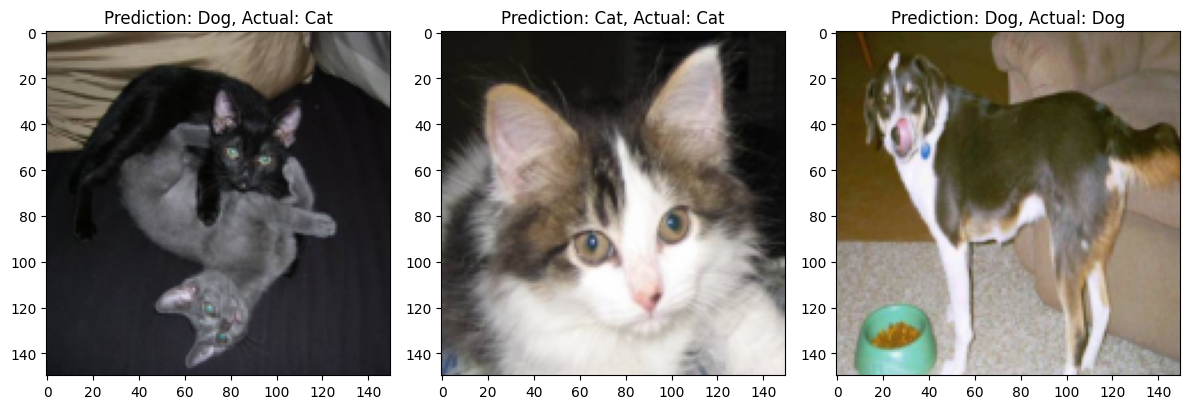

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Display img1 on the first subplot
axs[0].imshow(incorrect, cmap='gray')
axs[0].set_title('Prediction: Dog, Actual: Cat')

# Display img2 on the second subplot
axs[1].imshow(cat, cmap='gray')
axs[1].set_title('Prediction: Cat, Actual: Cat')

# Display img3 on the third subplot
axs[2].imshow(dog, cmap='gray')
axs[2].set_title('Prediction: Dog, Actual: Dog')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## Task 4(25 points)

In this task, we will create and train a UNet-based model from scratch to improve classification accuracy.

In [37]:
# Refer Task_4_Training.ipynb for the solution of task 4